- [20.2 - Hierarchical Bayesian Approach](#20.2---Hierarchical-Bayesian-Approach)

## Chapter 20 - Metric Predicted Variable with Multiple Nominal Predictors

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

In [200]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

### 20.2 - Hierarchical Bayesian Approach

In [166]:
df = pd.read_csv('data/Salary.csv', usecols=[0,3,5])

# Convert Org and Pos to category dtype.
df.loc[:,['Org', 'Pos']] = df.loc[:,['Org', 'Pos']].apply(lambda x: x.astype('category'))
# Reorder the Pos categories and rename categories
df.Pos.cat.reorder_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST'], ordered=True, inplace=True)
df.Pos.cat.rename_categories(['Assis', 'Assoc', 'Full', 'Endow', 'Disting'], inplace=True)

# Sort DataFrame by Pos
df.sort_values('Pos', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 226 to 736
Data columns (total 3 columns):
Org       1080 non-null category
Pos       1080 non-null category
Salary    1080 non-null int64
dtypes: category(2), int64(1)
memory usage: 19.5 KB


In [139]:
df.Pos.value_counts()

Assoc      364
Full       360
Assis      240
Endow       84
Disting     32
Name: Pos, dtype: int64

In [169]:
#df.Org.value_counts()

In [140]:
df.groupby('Pos').head(3)

       Org      Pos  Salary
226   SPEA    Assis  100319
730   OADT    Assis  150100
732   CEDP    Assis   76875
999   ECON    Assoc  154000
610   ELPS    Assoc   89644
492    ENG    Assoc   80868
185   KINE     Full  113500
815   ELPS     Full  122261
162   ANTH     Full   82035
120     BI    Endow  135236
750   CHEM    Endow  162685
1033  ANTH    Endow  116520
225   TELC  Disting  172930
572     BI  Disting  240026
467     BI  Disting  212385

In [202]:
subset_df.groupby(['Org', 'Pos']).mean()['Salary']

Org   Pos    
BFIN  Assis      197400.000000
      Assoc      217166.666667
      Full       238800.000000
      Endow      238900.000000
      Disting              NaN
CHEM  Assis       82711.500000
      Assoc      107533.875000
      Full       161343.333333
      Endow      181835.750000
      Disting    201313.750000
ENG   Assis       65266.666667
      Assoc       79414.333333
      Full       112599.250000
      Endow      105390.333333
      Disting              NaN
PSY   Assis       82265.166667
      Assoc       83679.222222
      Full       111994.800000
      Endow      193304.166667
      Disting    206974.200000
Name: Salary, dtype: float64

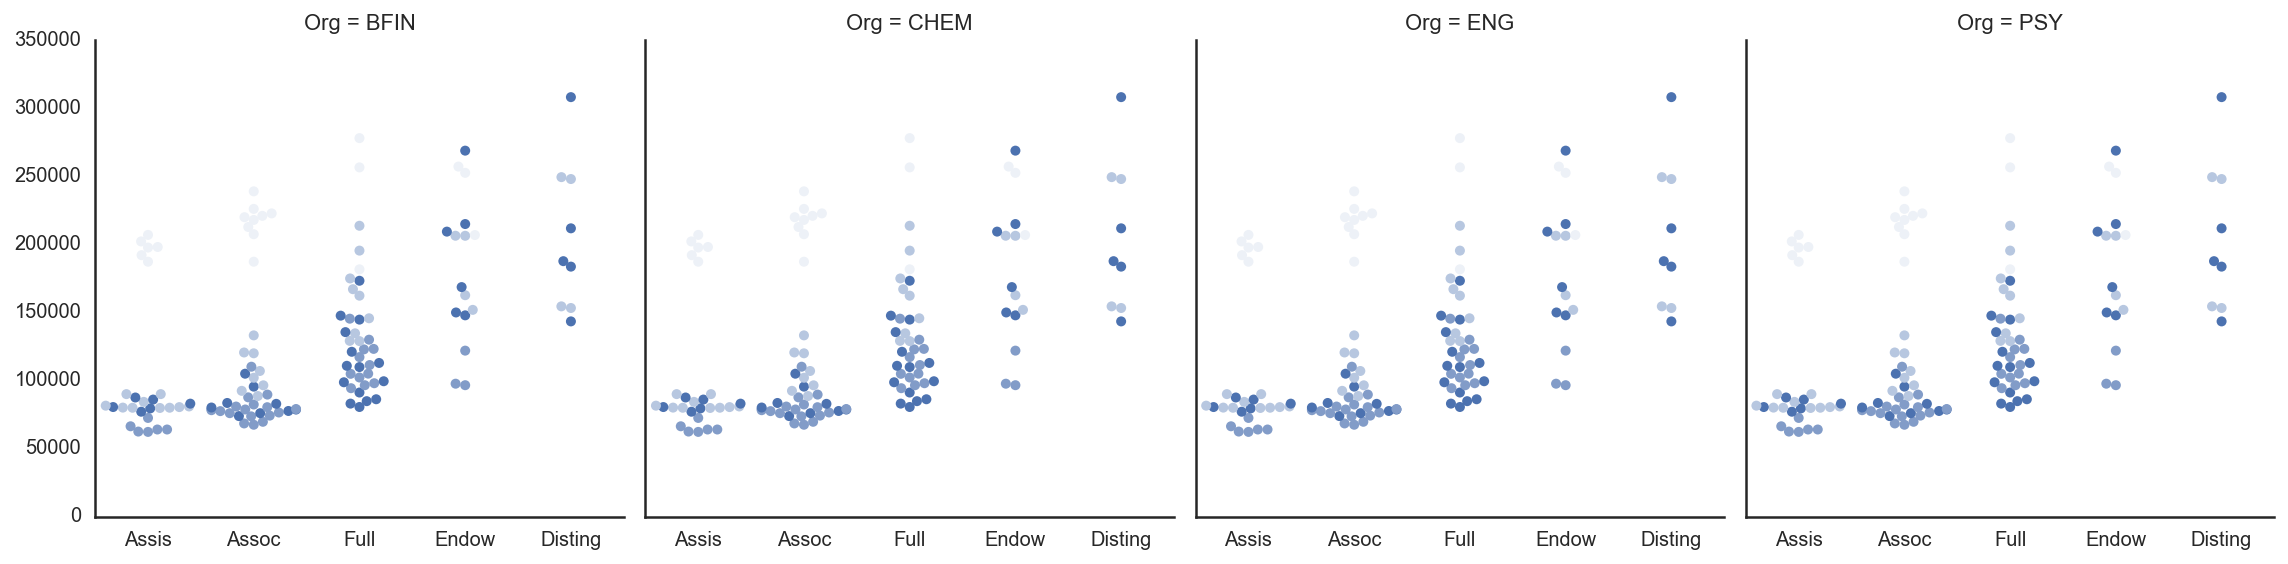

In [197]:
subset_org = ['BFIN', 'CHEM', 'PSY', 'ENG']
subset_df = df[df.Org.isin(subset_org)]
subset_df.Org.cat.remove_unused_categories(inplace=True)

fg = sns.FacetGrid(subset_df, col='Org', col_order=subset_org, size=4) 
fg.map(sns.swarmplot, x='Pos', y='Salary', hue='Org', data=subset_df)

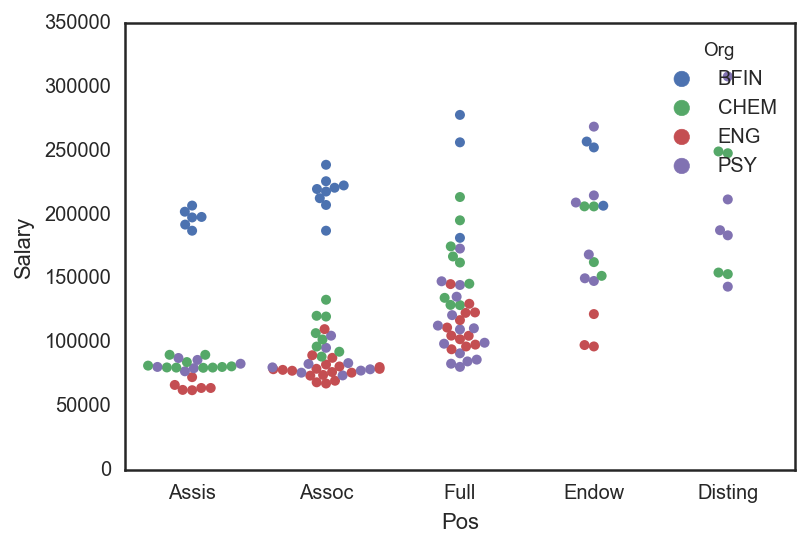

In [194]:
sns.swarmplot('Pos', 'Salary', 'Org', data=subset_df)

#### Model (Kruschke, 2015)

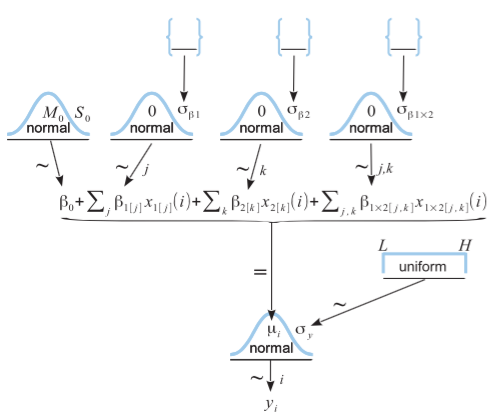

In [95]:
Image('images/fig20_2.png')

In [ ]:
  model {
    for ( i in 1:Ntotal ) {
      y[i] ~ dnorm( mu[i] , 1/ySigma^2 )
      mu[i] <- a0 + a1[x1[i]] + a2[x2[i]] + a1a2[x1[i],x2[i]]
    }
    ySigma ~ dunif( ySD/100 , ySD*10 )
    a0 ~ dnorm( yMean , 1/(ySD*5)^2 ) 
    #
    for ( j1 in 1:Nx1Lvl ) { a1[j1] ~ dnorm( 0.0 , 1/a1SD^2 ) }
    a1SD ~ dgamma(agammaShRa[1],agammaShRa[2]) # or try a folded t (Cauchy)
    #
    for ( j2 in 1:Nx2Lvl ) { a2[j2] ~ dnorm( 0.0 , 1/a2SD^2 ) }
    a2SD ~ dgamma(agammaShRa[1],agammaShRa[2]) # or try a folded t (Cauchy)
    #
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) {
      a1a2[j1,j2] ~ dnorm( 0.0 , 1/a1a2SD^2 )
    } }
    a1a2SD ~ dgamma(agammaShRa[1],agammaShRa[2]) # or try a folded t (Cauchy)
    # Convert a0,a1[],a2[],a1a2[,] to sum-to-zero b0,b1[],b2[],b1b2[,] :
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) {
      m[j1,j2] <- a0 + a1[j1] + a2[j2] + a1a2[j1,j2] # cell means 
    } }
    b0 <- mean( m[1:Nx1Lvl,1:Nx2Lvl] )
    for ( j1 in 1:Nx1Lvl ) { b1[j1] <- mean( m[j1,1:Nx2Lvl] ) - b0 }
    for ( j2 in 1:Nx2Lvl ) { b2[j2] <- mean( m[1:Nx1Lvl,j2] ) - b0 }
    for ( j1 in 1:Nx1Lvl ) { for ( j2 in 1:Nx2Lvl ) {
      b1b2[j1,j2] <- m[j1,j2] - ( b0 + b1[j1] + b2[j2] )  
    } }
  }

In [209]:
y = df.Salary
yMean = y.mean()
ySD = y.std()

x1 = df.Pos.cat.codes.values
Nx1Lvl = len(df.Pos.cat.categories)

x2 = df.Org.cat.codes.values
Nx2Lvl = len(df.Org.cat.categories)

agammaShRa = gammaShRaFromModeSD(ySD/2 , 2*ySD)

with pmc.Model() as model1:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a1SD = pmc.Gamma('a1SD', agammaShRa[0], agammaShRa[1])
    a1 = pmc.Normal('a1', 0.0, tau=1/a1SD**2, shape=Nx1Lvl)
    a2SD = pmc.Gamma('a2SD', agammaShRa[0], agammaShRa[1])
    a2 = pmc.Normal('a2', 0.0, tau=1/a2SD**2, shape=Nx2Lvl)
    
    a1a2SD = pmc.Gamma('a1a2SD', agammaShRa[0], agammaShRa[1])
    a1a2 = pmc.Normal('a1a2', 0.0, 1/a1a2SD**2, shape=(Nx1Lvl, Nx2Lvl))
        
    ySigma = pmc.Uniform('ySigma', ySD/100, ySD*10)
    mu = a0 + a1[x1] + a2[x2] +a1a2[x1, x2]
    like = pmc.Normal('y', mu, tau=1/ySigma**2, observed=y)
    
    # Convert a0,a1[],a2[],a1a2[,] to sum-to-zero b0,b1[],b2[],b1b2[,] : 
    #m = pmc.Deterministic('m', a0 + a1 + a2 + a1a2)
    #b0 = pmc.Deterministic('b0', tt.mean(m))
    #b1 = pmc.Deterministic('b1', m - b0) 
    #b2 = pmc.Deterministic('b2', m - b0)
    #b1b2 = pmc.Deterministic('b1b2', m - (b0 + b1 + b2))

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied log-transform to a1SD and added transformed a1SD_log_ to model.
Applied log-transform to a2SD and added transformed a2SD_log_ to model.
Applied log-transform to a1a2SD and added transformed a1a2SD_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.


In [213]:
with model1:
    trace1 = pmc.sample(2500)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a1SD_log_
Assigned NUTS to a1
Assigned NUTS to a2SD_log_
Assigned NUTS to a2
Assigned NUTS to a1a2SD_log_
Assigned NUTS to a1a2
Assigned NUTS to ySigma_interval_
 [-----------------100%-----------------] 2500 of 2500 complete in 45.6 sec

In [259]:
pmc.df_summary(trace1, varnames=['a1a2']).iloc[110:]

                    mean            sd    mc_error       hpd_2.5      hpd_97.5
a1a2__1_50   1111.996032   7501.219728  180.711942 -14313.324094  15528.573679
a1a2__1_51   -682.066136   7621.931266  183.054011 -14990.221226  15437.730050
a1a2__1_52   -448.542033   8132.337921  162.340414 -16614.649609  15524.291737
a1a2__1_53   -291.398040   6953.302338  134.703685 -14389.471697  12577.358004
a1a2__1_54  -2504.166011   7172.707263  186.134793 -16591.405545  11699.868731
a1a2__1_55  -4786.513747   6088.362230  186.399997 -16323.997641   7490.691673
a1a2__1_56  -4206.910376   7672.239476  168.389143 -19651.148340  10464.443787
a1a2__1_57  -2004.435195   9001.839848  146.385793 -20291.661208  15027.296721
a1a2__1_58  -2060.737311   8169.171388  148.559953 -18507.811502  13253.623974
a1a2__1_59  -3079.674343   8092.624911  226.382953 -17812.638373  13202.665598
a1a2__2_0  -12372.665384   7272.666805  185.576406 -24969.649180   3051.527480
a1a2__2_1   -1488.251184   8479.263192  195.854649 -